# **IRB Retail Mortgage**
# **PD Model Calibration and Validation**

This notebook evaluates the robustness, stability, and calibration of the developed PD model. While the model specification and coefficients were finalised using the full development universe, this notebook assesses whether the frozen model behaves consistently across different data slices, thereby validating its suitability for deployment and regulatory use.

## **Loading the Dataset**

In [1]:
# importing the required modules
import sys
sys.path.append("..")

from src.config import *
from src.utility_functions import *

In [2]:
# loading the dataset after modelling
model_df = save_as_pickle_if_not_exists_and_load(pickle_file_path = f"{main_dir}/data/processed/mortgage_data_with_predictions.pkl")
model_df.head(5)

Pickle file already exists at: /Users/sharmadipanshu/Developer/KPMG/irb_retail_pd_sas_vs_python//data/processed/mortgage_data_with_predictions.pkl
(2260668, 86)


,id,term,loan_amnt,int_rate,installment,grade,sub_grade,purpose,verification_status,annual_inc,emp_length,home_ownership,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,t0,default_flag,clubbed_term,clubbed_sub_grade,clubbed_purpose,clubbed_verification_status,clubbed_home_ownership,clubbed_emp_length,clubbed_term_woe,clubbed_term_iv,clubbed_sub_grade_woe,clubbed_sub_grade_iv,clubbed_purpose_woe,clubbed_purpose_iv,clubbed_verification_status_woe,clubbed_verification_status_iv,clubbed_home_ownership_woe,clubbed_home_ownership_iv,clubbed_emp_length_woe,clubbed_emp_length_iv,delinq_2yrs_adj,clubbed_delinq_2yrs,clubbed_delinq_2yrs_woe,clubbed_delinq_2yrs_iv,inq_last_6mths_adj,clubbed_inq_last_6mths,clubbed_inq_last_6mths_woe,clubbed_inq_last_6mths_iv,pub_rec_adj,clubbed_pub_rec,clubbed_pub_rec_woe,clubbed_pub_rec_iv,open_acc_adj,clubbed_open_acc,clubbed_open_acc_woe,clubbed_open_acc_iv,total_acc_adj,clubbed_total_acc,clubbed_total_acc_woe,clubbed_total_acc_iv,loan_amnt_category,loan_amnt_bin_id,loan_amnt_woe,int_rate_category,int_rate_bin_id,int_rate_woe,installment_category,installment_bin_id,installment_woe,annual_inc_category,annual_inc_bin_id,dti_category,dti_bin_id,revol_bal_category,revol_bal_bin_id,revol_bal_woe,revol_util_category,revol_util_bin_id,dti_bin_id_adj,annual_inc_bin_id_adj,revol_util_bin_id_adj,dti_woe,annual_inc_woe,revol_util_woe,pd_hat,decile
774204,139972821,60 months,10400.0000,22.3500,289.3200,D,D5,debt_consolidation,Not Verified,0.0000,NaN,RENT,NaN,1.0000,1.0000,5.0000,0.0000,0.0000,NaN,23.0000,2018-09-30,0,60 months,D5,1. medium_risk,Not Verified,1. rent,unknown,-0.3569,0.0419,-0.6693,0.0122,-0.0923,0.0051,0.4333,0.0524,-0.1773,0.0133,-0.2178,0.0033,1,1,-0.0810,0.0008,1,1,-0.1399,0.0053,0,0,0.0475,0.0019,2. 3_5,2. 3_5,0.1796,0.0028,4. 21_30,4. 21_30,-0.0119,0.0000,10025.0 - 15000.0,3,-0.0778,20.9 - 30.99,8,-0.9367,230.64 - 327.69,2,0.0459,0.0 - 39502.0,0,missing,-1,0.0 - 22577.0,0,-0.0333,missing,-1,0,0,0,0.3402,-0.2090,0.4562,0.1937,8
1488539,135666561,60 months,12000.0000,17.4700,301.2800,D,D1,credit_card,Not Verified,0.0000,NaN,RENT,NaN,0.0000,0.0000,1.0000,0.0000,0.0000,NaN,3.0000,2018-06-30,0,60 months,D1,0. low_risk,Not Verified,1. rent,unknown,-0.3569,0.0419,-0.4494,0.0086,0.2187,0.0135,0.4333,0.0524,-0.1773,0.0133,-0.2178,0.0033,0,0,0.0289,0.0007,0,0,0.1971,0.0220,0,0,0.0475,0.0019,1. 0_2,1. 0_2,0.2806,0.0004,1. 0_5,1. 0_5,0.1930,0.0005,10025.0 - 15000.0,3,-0.0778,15.1 - 17.47,6,-0.4327,230.64 - 327.69,2,0.0459,0.0 - 39502.0,0,missing,-1,0.0 - 22577.0,0,-0.0333,missing,-1,0,0,0,0.3402,-0.2090,0.4562,0.1414,6
2081649,122649959,36 months,16800.0000,9.9300,541.5400,B,B2,debt_consolidation,Not Verified,0.0000,NaN,MORTGAGE,NaN,0.0000,0.0000,2.0000,0.0000,0.0000,NaN,10.0000,2017-11-30,0,36 months,B2,1. medium_risk,Not Verified,0. owned,unknown,0.1765,0.0207,0.6412,0.0180,-0.0923,0.0051,0.4333,0.0524,0.1304,0.0098,-0.2178,0.0033,0,0,0.0289,0.0007,0,0,0.1971,0.0220,0,0,0.0475,0.0019,1. 0_2,1. 0_2,0.2806,0.0004,2. 6_10,2. 6_10,0.1058,0.0009,15025.0 - 40000.0,4,-0.0971,8.88 - 10.47,2,0.6826,327.7 - 1246.76,3,-0.0898,0.0 - 39502.0,0,missing,-1,0.0 - 22577.0,0,-0.0333,missing,-1,0,0,0,0.3402,-0.2090,0.4562,0.0486,1
2100238,123937016,36 months,20000.0000,10.4200,649.3000,B,B3,debt_consolidation,Not Verified,0.0000,NaN,MORTGAGE,NaN,1.0000,0.0000,2.0000,0.0000,0.0000,NaN,13.0000,2017-11-30,0,36 months,B3,1. medium_risk,Not Verified,0. owned,unknown,0.1765,0.0207,0.4299,0.0091,-0.0923,0.0051,0.4333,0.0524,0.1304,0.0098,-0.2178,0.0033,1,1,-0.0810,0.0008,0,0,0.1971,0.0220,0,0,0.0475,0.0019,1. 0_2,1. 0_2,0.2806,0.0004,3. 11_20,3. 11_20,0.0264,0.0002,15025.0 - 40000.0,4,-0.0971,8.88 - 10.47,2,0.6826,327.7 - 1246.76,3,-0.0898,0.0 - 39502.0,0,missing,-1,0.0 - 22577.0,0,-0.0333,missing,-1,0,0,0,0.3402,-0.2090,0.4562,0.0580,2
1654329,79967,36 months,5000.0000,7.4300,155.3800,A,A2,other,Not Verified,NaN,< 1 year,NONE,1.0000,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,2007-08-31,0,36 months,A2,2. high_ri

In [3]:
# loading the final model 
final_model_summary = pd.read_excel(f"{main_dir}/summaries_and_charts/final_model_metrics.xlsx", sheet_name=None)
final_model_summary.keys()

dict_keys(['final_model_summary', 'decile_summary', 'statistics'])

## **Calibration and Validation Sample (OOT)**

Given the snapshot nature of the available dataset, the model was developed using the full sample to ensure robust variable selection and stable coefficient estimation. Sice the recent dataset is not available, the validation exercise conducted in this notebook represents a pseudo out-of-time (OOT) analysis, rather than a fully independent holdout validation. The purpose of this pseudo-OOT analysis is not to re-assess model specification, but to evaluate the stability, rank-order preservation, and calibration behaviour of the frozen model across different time slices. This approach is consistent with industry practice when true OOT samples are not available and is intended to demonstrate key elements of the IRB model development and validation lifecycle.

In [4]:
model_df['year'] = model_df.t0.dt.year 
display(model_df.t0.value_counts(dropna=False).sort_index())
display(model_df.year.value_counts(dropna=False).sort_index())

t0
2007-06-30       24
2007-07-31       63
2007-08-31       74
2007-09-30       53
2007-10-31      105
              ...  
2018-08-31    46079
2018-09-30    39026
2018-10-31    46305
2018-11-30    41973
2018-12-31    40134
Name: count, Length: 139, dtype: int64

year
2007       603
2008      2393
2009      5281
2010     12537
2011     21721
2012     53367
2013    134814
2014    235629
2015    421095
2016    434407
2017    443579
2018    495242
Name: count, dtype: int64

In [18]:
# we have the dataset from Jun'2007 to Dec'2028
# lets calculate the yearwise default rate and then create 5 years window and calculate the LRADR

yearwise_default_rate = model_df.groupby('year').agg({'default_flag' : ['count', 'sum', 'mean']}).reset_index()
yearwise_default_rate['5year_lradr'] = yearwise_default_rate[('default_flag', 'mean')].rolling(5).mean()
display(yearwise_default_rate)

print(f"LRADR 2007 - 2018 : {round(yearwise_default_rate[('default_flag', 'mean')].mean()*100, 4)}%")


year default_flag               5year_lradr
                count    sum   mean            
0   2007          603    158 0.2620         NaN
1   2008         2393    496 0.2073         NaN
2   2009         5281    723 0.1369         NaN
3   2010        12537   1757 0.1401         NaN
4   2011        21721   3297 0.1518      0.1796
5   2012        53367   8644 0.1620      0.1596
6   2013       134814  21024 0.1559      0.1494
7   2014       235629  41162 0.1747      0.1569
8   2015       421095  75804 0.1800      0.1649
9   2016       434407  68252 0.1571      0.1659
10  2017       443579  39169 0.0883      0.1512
11  2018       495242   8874 0.0179      0.1236

LRADR 2007 - 2018 : 15.2841%


The available dataset spans loan vintages from June 2007 to December 2018, with a material increase in portfolio size and data completeness from 2012 onwards. Earlier vintages (2007–2010) exhibit relatively low observation counts and are heavily influenced by the global financial crisis, making them less representative of the current risk profile of the portfolio. Consequently, for the purpose of calibration and validation, the analysis focuses on the more recent and statistically robust period starting from 2013, where annual observations exceed 130,000 accounts and default behaviour stabilises.

In line with industry practice and supervisory expectations for IRB models, a five-year window (2013–2017) is selected as the calibration sample to estimate the Long-Run Average Default Rate (LRADR) and perform portfolio-level PD alignment. This period provides sufficient depth to smooth short-term volatility while remaining representative of recent credit conditions. The 2018 vintage, comprising approximately 495,000 observations, is designated as the out-of-time (OOT) validation sample. Although the model was developed using the full snapshot of data, this split enables a pseudo-OOT assessment of rank-order stability, calibration behaviour, and score distribution consistency across time, thereby supporting the evaluation of model robustness and fitness for use.

In [6]:
calibration_period = (2013, 2017)
oot_period = (2018, 2018)

calib_data = model_df[model_df.year.between(calibration_period[0], calibration_period[1])]
oot_data = model_df[model_df.year.between(oot_period[0], oot_period[1])]
print(calib_data.shape, oot_data.shape)

(1669524, 87) (495242, 87)


### **LRADR and Calibration**

In [7]:
# calculating the scorebased on the final selected model
final_vars = final_model_summary['final_model_summary']['variable'].to_list()
final_vars.remove('const')

# extract coefficients (including intercept)
coef_df = final_model_summary['final_model_summary'].set_index('variable')
intercept = coef_df.loc['const', 'coefficient']
betas = coef_df.loc[final_vars, 'coefficient']

# apply frozen model
calib_data['pd_raw'] = score_pd(calib_data, betas, intercept)
oot_data['pd_raw']   = score_pd(oot_data, betas, intercept)

display(calib_data[['pd_raw']].describe()) 
display(oot_data[['pd_raw']].describe())

# calculating the target (LRADR) and existing average predicted PD
LRADR = calib_data.groupby('year').agg({'default_flag' : 'mean'}).reset_index()['default_flag'].mean()
avg_pd_calib = calib_data.pd_raw.mean()
print(f"Target (LRADR) : {round(LRADR*100,4)}%\nAverage Existing Predicted PD: {round(avg_pd_calib*100,4)}%") 


,pd_raw
count,1669524.0000
mean,0.1244
std,0.0811
min,0.0096
25%,0.0645
50%,0.1088
75%,0.1648
max,0.5687


,pd_raw
count,495242.0000
mean,0.1007
std,0.0682
min,0.0084
25%,0.0462
50%,0.0875
75%,0.1400
max,0.5289


Target (LRADR) : 15.1214%
Average Existing Predicted PD: 12.4426%


$$\Delta = log(\frac{LRADR}{1-LRADR}) - log(\frac{\bar{PD}}{1-\bar{PD}})$$

Δ represents the difference between long-run log-odds of default and the model-implied log-odds of default

Economically:
- If Δ > 0 → model under-predicts risk → shift PDs upward
- If Δ < 0 → model over-predicts risk → shift PDs downward

Crucially:
- Only the intercept is adjusted
- Rank-ordering and marginal effects remain intact

This is intercept-only calibration, as expected under IRB.

In [8]:
# intercept shift (delta)
delta = np.log(LRADR / (1 - LRADR)) - np.log(avg_pd_calib / (1 - avg_pd_calib))
print(f"Intercept Shift (Delta): {round(delta, 6)}")

# applying calibrated PDs — calibration sample
calib_data['pd_calibrated'] = 1 / (1 + np.exp(-(np.log(calib_data['pd_raw'] / (1 - calib_data['pd_raw'])) + delta)))

# applying calibrated PDs — OOT sample
oot_data['pd_calibrated'] = 1 / (1 + np.exp(-(np.log(oot_data['pd_raw'] / (1 - oot_data['pd_raw'])) + delta)))

# Validation check
print("Post-calibration average PD (Calibration sample):", round(calib_data['pd_calibrated'].mean()*100, 4), "%")
print("LRADR: ", round(LRADR*100, 4), "%")

Intercept Shift (Delta): 0.226059
Post-calibration average PD (Calibration sample): 14.9349 %
LRADR:  15.1214 %


The PD model is calibrated using an intercept-only adjustment to align portfolio-level predicted default rates with the Long-Run Average Default Rate (LRADR), estimated over the 2013–2017 calibration window. The LRADR for this period is 15.12%, representing a stable long-run estimate of portfolio credit risk after smoothing cyclical fluctuations.

Following the application of the calibrated intercept, the average predicted PD on the calibration sample increases from 12.44% (pre-calibration) to 14.93% (post-calibration), bringing the model outputs into close alignment with the LRADR. The residual difference of approximately 19 basis points is economically immaterial and arises due to the non-linear transformation between log-odds and probability space, as well as differences between population-weighted PD averages and time-averaged default rates.

Importantly, the calibration is performed through an intercept-only shift, leaving all slope coefficients unchanged. As a result, the model’s rank-ordering, relative risk differentiation, and discriminatory power are fully preserved. This calibration approach is consistent with IRB modelling principles and ensures portfolio-level PD alignment while maintaining model stability and interpretability.

### **Sample Performance**

#### **Calibration**

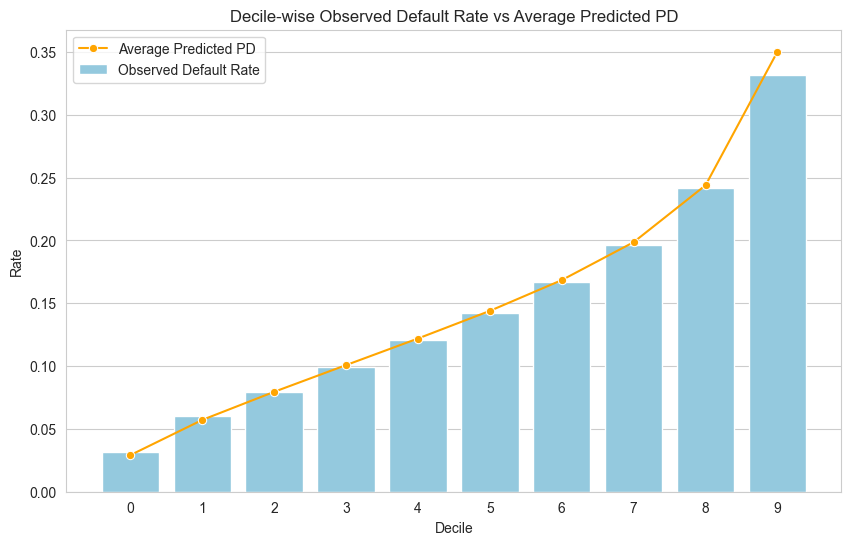

AUC: 69.34%
Final Model Gini: 38.67%
KS Statistic: 0.2786


,decile,population,defaults,avg_pd,obs_default_rate,cum_good,cum_bad,ks
0,0,167371,5300,0.0291,0.0317,0.1138,0.0216,0.0922
1,1,166620,10000,0.0572,0.0600,0.2238,0.0623,0.1614
2,2,166879,13299,0.0795,0.0797,0.3316,0.1165,0.2151
3,3,166945,16558,0.1008,0.0992,0.4372,0.1840,0.2532
4,4,166947,20164,0.1219,0.1208,0.5403,0.2662,0.2741
5,5,166991,23756,0.1439,0.1423,0.6409,0.3630,0.2779
6,6,166914,27871,0.1684,0.1670,0.7385,0.4765,0.2620
7,7,166954,32736,0.1986,0.1961,0.8328,0.6099,0.2228
8,8,166968,40365,0.2439,0.2418,0.9217,0.7744,0.1472
9,9,166935,55362,0.3502,0.3316,1.0000,1.0000,0.0000


In [9]:
calib_decile_summary, calib_decile_fig, calib_auc, calib_gini, calib_ks = performance_summary(calib_data, 'pd_calibrated', 'default_flag', 10)

print(f"AUC: {round(calib_auc*100, 2)}%")
print(f"Final Model Gini: {round(calib_gini*100, 2)}%")
print(f"KS Statistic: {calib_ks:.4f}")
display(calib_decile_summary)

On the calibration sample, the calibrated model demonstrates strong discriminatory power and good calibration alignment. The AUC of 69.3% (Gini 38.7%) and KS of 0.279 are consistent with the development-stage performance observed in Notebook 03, indicating that the frozen model structure remains stable when reapplied to the calibration window. Rank-ordering is well preserved, with a smooth and monotonic increase in observed default rates across deciles, confirming that the model effectively separates higher-risk from lower-risk accounts.

From a calibration perspective, the intercept-only adjustment successfully aligns the portfolio-level average predicted PD with the Long-Run Average Default Rate (LRADR) estimated over the five-year window. Post-calibration, the average predicted PD in the calibration sample closely matches the LRADR, with only a small residual difference attributable to rounding and numerical aggregation effects. At the decile level, predicted PDs track observed default rates reasonably well, particularly in the central deciles, indicating that the calibration shift preserves relative risk differentiation while correcting level bias at the portfolio level.

Overall, the calibration results confirm that the model is well-calibrated on a long-run representative sample, with no evidence of rank-order instability or excessive concentration of risk in individual deciles.

#### **OOT**

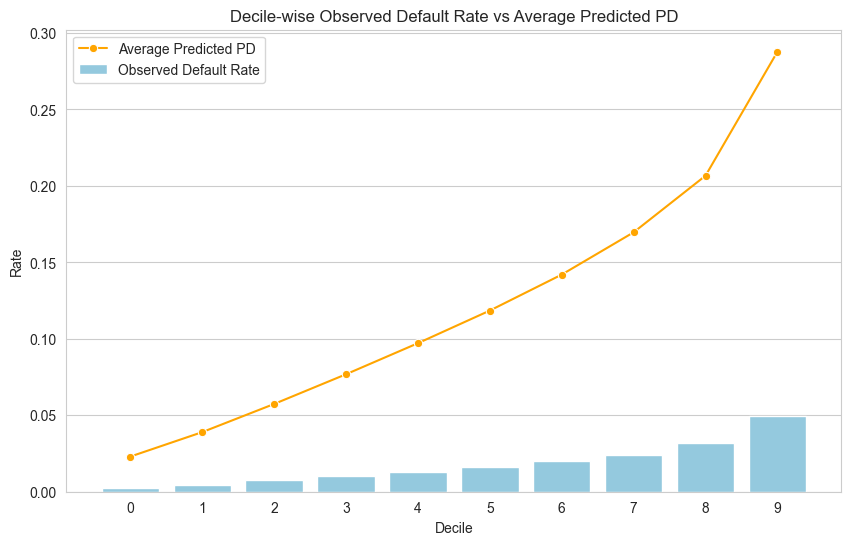

AUC: 70.98%
Final Model Gini: 41.95%
KS Statistic: 0.3054


,decile,population,defaults,avg_pd,obs_default_rate,cum_good,cum_bad,ks
0,0,49553,130,0.0230,0.0026,0.1016,0.0146,0.0870
1,1,49496,217,0.0390,0.0044,0.2029,0.0391,0.1638
2,2,49566,388,0.0574,0.0078,0.3040,0.0828,0.2212
3,3,49509,507,0.0768,0.0102,0.4048,0.1400,0.2648
4,4,49539,628,0.0971,0.0127,0.5054,0.2107,0.2946
5,5,49600,807,0.1185,0.0163,0.6057,0.3017,0.3040
6,6,49408,987,0.1420,0.0200,0.7052,0.4129,0.2924
7,7,49527,1193,0.1696,0.0241,0.8046,0.5473,0.2573
8,8,49520,1575,0.2066,0.0318,0.9032,0.7248,0.1784
9,9,49524,2442,0.2877,0.0493,1.0000,1.0000,0.0000


In [10]:
oot_decile_summary, oot_decile_fig, oot_auc, oot_gini, oot_ks = performance_summary(oot_data, 'pd_calibrated', 'default_flag', 10)

print(f"AUC: {round(oot_auc*100, 2)}%")
print(f"Final Model Gini: {round(oot_gini*100, 2)}%")
print(f"KS Statistic: {oot_ks:.4f}")
display(oot_decile_summary)

In the OOT sample (2018), the model continues to exhibit strong discriminatory performance, with an AUC of 71.0% (Gini 42.0%) and KS of 0.305—both marginally higher than those observed in the calibration sample. This indicates that the rank-ordering capability of the model remains robust out of time, and that relative risk signals learned during development continue to generalise well to later vintages.

However, a clear level misalignment is observed between predicted PDs and realised default rates in the OOT period. Across all deciles, the model systematically over-predicts default risk, with observed default rates substantially lower than calibrated PDs. This behaviour is economically intuitive and consistent with earlier portfolio-level analysis, which showed that 2018 exhibits the lowest annual default rate (~1.8%) in the dataset, reflecting a benign credit environment and improved borrower performance relative to the long-run average.

Importantly, this over-prediction does not indicate model failure. The calibration was intentionally anchored to the LRADR rather than to point-in-time conditions, in line with IRB principles. As a result, in periods where realised default rates fall materially below long-run levels, conservative bias in predicted PDs is expected and, from a regulatory perspective, desirable. Crucially, rank-order stability is preserved in the OOT sample, with monotonic observed default rates across deciles and no evidence of score inversion.

### **Stability Diagnostics**

While the model was developed on the full snapshot, additional stability diagnostics are performed by comparing development-period observations with the 2018 out-of-time vintage to provide indicative evidence of temporal stability.”

In [11]:
# creating pd_calibrated in dev data 
model_df['pd_raw'] = score_pd(model_df, betas, intercept)
model_df['pd_calibrated'] = 1 / (1 + np.exp(-(np.log(model_df['pd_raw'] / (1 - model_df['pd_raw'])) + delta)))

pd_bins = [0, 0.02, 0.05, 0.1, 0.2, 0.4, 1.0]
for df in [model_df, calib_data, oot_data]:
    df['pd_bucket'] = pd.cut(df['pd_calibrated'], bins=pd_bins)

PSI Calibrated PD (Dev vs OOT): 0.06352355376142073
PSI Calibrated PD (Calib vs OOT): 0.1053610005117795


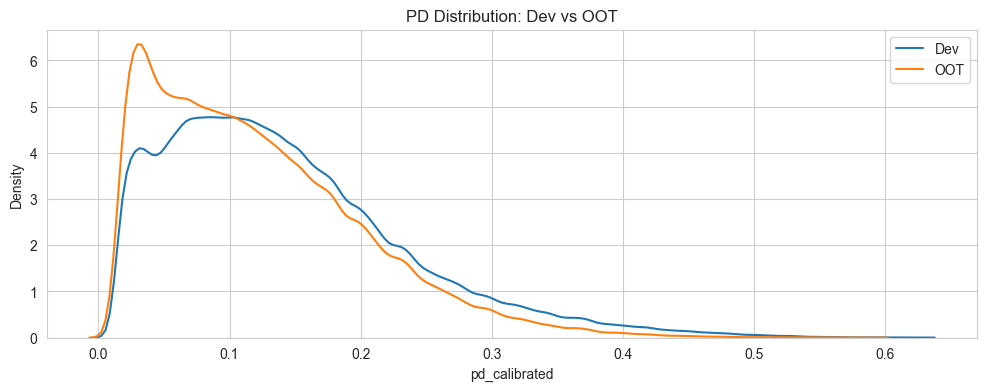

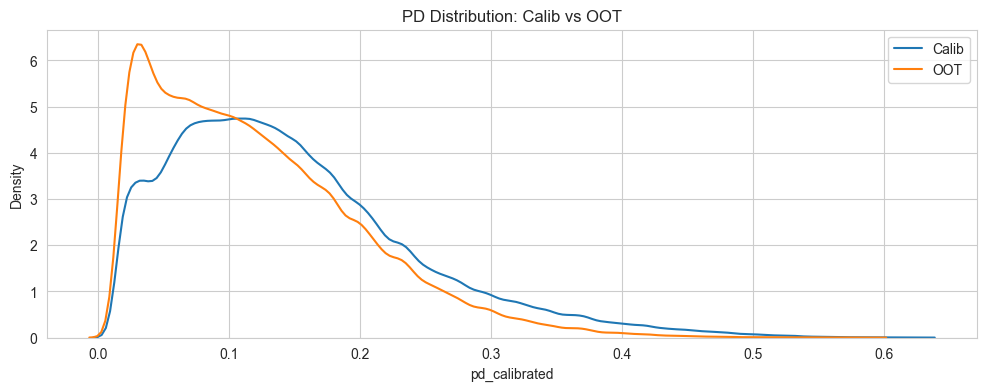

In [15]:
# PSI on pd buckets 
psi_dev_oot = stability_index(model_df['pd_bucket'],oot_data['pd_bucket'])
psi_calib_oot = stability_index(calib_data['pd_bucket'], oot_data['pd_bucket'])
print(f'PSI Calibrated PD (Dev vs OOT): {psi_dev_oot}')
print(f'PSI Calibrated PD (Calib vs OOT): {psi_calib_oot}')

# calibrated PD Distribution comparison 
fig_dev_vs_oot = plt.figure(figsize=(12,4))
sns.kdeplot(model_df['pd_calibrated'], label='Dev')
sns.kdeplot(oot_data['pd_calibrated'], label='OOT')
plt.title('PD Distribution: Dev vs OOT')
plt.legend()
plt.show()


fig_calib_vs_oot = plt.figure(figsize=(12,4))
sns.kdeplot(calib_data['pd_calibrated'], label='Calib')
sns.kdeplot(oot_data['pd_calibrated'], label='OOT')
plt.title('PD Distribution: Calib vs OOT')
plt.legend()
plt.show()

The PD distribution comparison indicates a clear and economically intuitive shift between the reference samples and the OOT population. In both Dev vs OOT and Calibration vs OOT comparisons, the OOT distribution is visibly left-shifted, with a higher concentration of observations at lower PD levels and a thinner right tail. This behaviour is consistent with the substantially lower observed default rate in the 2018 vintage (≈1.8%) relative to the calibration window (2013–2017), reflecting more benign credit conditions rather than deterioration in model performance.

The Population Stability Index (PSI) values further support this conclusion. The PSI for calibrated PDs (Dev vs OOT) is approximately 0.064, while Calibration vs OOT is approximately 0.105. Both values are well below commonly used supervisory thresholds (e.g. 0.1 for no material shift and 0.25 for significant shift). The slightly higher PSI when comparing Calibration to OOT is expected, as the calibration period was explicitly anchored to a higher long-run default environment, whereas the OOT year represents a cyclical low. Importantly, these shifts do not indicate rank-order breakdown or model instability.

In [16]:
# CSI on final selected variables 
csi_results = []

for var in ['annual_inc_bin_id_adj','clubbed_inq_last_6mths','clubbed_sub_grade', 'clubbed_verification_status', 'clubbed_home_ownership','dti_bin_id_adj']:
    csi_results.append({
        'variable': var,
        'CSI_Dev_vs_OOT': stability_index(model_df[var], oot_data[var]),
        'CSI_Calib_vs_OOT': stability_index(calib_data[var], oot_data[var])
    })

csi_df = pd.DataFrame(csi_results)
display(csi_df)


,variable,CSI_Dev_vs_OOT,CSI_Calib_vs_OOT
0,annual_inc_bin_id_adj,0.0038,0.0059
1,clubbed_inq_last_6mths,0.0358,0.0459
2,clubbed_sub_grade,0.0707,0.1185
3,clubbed_verification_status,0.0413,0.0673
4,clubbed_home_ownership,0.0003,0.0008
5,dti_bin_id_adj,0.0081,0.0137


Characteristic Stability Indices (CSI) were computed for all final selected drivers using their original categorical representations, ensuring that the analysis captures genuine portfolio mix changes rather than artefacts of WOE scaling. Across all variables, CSI values remain very low for both comparisons:

- Dev vs OOT: CSI values range from approximately 0.0003 to 0.071
- Calibration vs OOT: CSI values range from approximately 0.0008 to 0.119

Among the drivers, sub-grade exhibits the highest CSI in the Calibration vs OOT comparison (~0.12), which is consistent with a gradual improvement in credit quality mix during 2018. Other behavioural and affordability variables (e.g. inquiries, DTI, income bands) display only minor distributional shifts, well below levels that would trigger concern. Overall, the CSI results indicate no material population instability across key risk drivers.

The observed PD and characteristic shifts are economically explainable and acceptable. The OOT period coincides with a phase of strong credit performance, lower realised defaults, and improved borrower profiles, naturally leading to lower predicted and observed PDs. Importantly, these shifts are directionally consistent across PD distributions, decile behaviour, and driver-level CSI, reinforcing that the model continues to discriminate risk appropriately rather than reacting to noise or structural breaks.

Taken together, the stability diagnostics confirm that the model exhibits robust rank-ordering, stable driver behaviour, and controlled distributional drift. The differences observed between the reference samples and OOT reflect cyclical credit dynamics rather than model degradation, supporting the model’s suitability for ongoing use under an IRB framework.

## **Output**

In [21]:
final_model_summary['final_model_summary']['delta'] = delta
final_model_summary['final_model_summary']

,variable,coefficient,p_values,vif,contribution_pct,gini,economic_driver,delta
0,const,-2.0023,0.0000,NaN,NaN,0.4068,NaN,0.2261
1,annual_inc_woe,-0.5218,0.0000,1.1192,0.0814,0.4068,affordability,0.2261
2,clubbed_inq_last_6mths_woe,-0.5460,0.0000,1.0560,0.1068,0.4068,behavioural,0.2261
3,clubbed_sub_grade_woe,-0.8797,0.0000,1.2008,0.5581,0.4068,credit_quality,0.2261
4,clubbed_verification_status_woe,-0.4424,0.0000,1.0920,0.1077,0.4068,customer_profile,0.2261
5,clubbed_home_ownership_woe,-0.6859,0.0000,1.0602,0.0829,0.4068,customer_profile,0.2261
6,dti_woe,-0.3756,0.0000,1.0910,0.0631,0.4068,affordability,0.2261


In [25]:
yearwise_default_rate.columns = ['year', 'pop', 'def', 'def_rate', 'lradr_5year']
yearwise_default_rate

,year,pop,def,def_rate,lradr_5year
0,2007,603,158,0.2620,NaN
1,2008,2393,496,0.2073,NaN
2,2009,5281,723,0.1369,NaN
3,2010,12537,1757,0.1401,NaN
4,2011,21721,3297,0.1518,0.1796
5,2012,53367,8644,0.1620,0.1596
6,2013,134814,21024,0.1559,0.1494
7,2014,235629,41162,0.1747,0.1569
8,2015,421095,75804,0.1800,0.1649
9,2016,434407,68252,0.1571,0.1659


In [26]:
model_validation_and_calibration_results = {
    'yearwise_default_rate' : yearwise_default_rate,
    'model_summary_w_delta' : final_model_summary['final_model_summary'],
    'calib_params' : pd.DataFrame({'LRADR' : LRADR, 'Avg Pred. PD' : avg_pd_calib, 'delta': delta}, index = [0]),
    'calib_decile_summary' : calib_decile_summary, 
    'calib_performance' : pd.DataFrame({'AUC': calib_auc, 'Gini' : calib_gini, 'KS': calib_ks}, index = [0]),
    'oot_decile_summary' : oot_decile_summary, 
    'oot_performance' : pd.DataFrame({'AUC': oot_auc, 'Gini' : oot_gini, 'KS': oot_ks}, index = [0]),
    'pd_calibration_psi' : pd.DataFrame({'dev_vs_oot' : psi_dev_oot, 'calib_vs_oot': psi_calib_oot}, index = [0]),
    'csi' : csi_df 
}

# exporting the results 
export_dict_to_excel(model_validation_and_calibration_results, file_path=f"{main_dir}/summaries_and_charts/model_validation_and_calibration_results.xlsx")


calib_decile_fig.savefig(f"{main_dir}/summaries_and_charts/decile_summary_plot_calibration.png", dpi=300)
oot_decile_fig.savefig(f"{main_dir}/summaries_and_charts/decile_summary_plot_oot.png", dpi=300)

fig_dev_vs_oot.savefig(f"{main_dir}/summaries_and_charts/pd_calibration_distribution_dev_vs_oot.png", dpi=300)
fig_calib_vs_oot.savefig(f"{main_dir}/summaries_and_charts/pd_calibration_distribution_calib_vs_oot.png", dpi=300)

Excel file saved at: /Users/sharmadipanshu/Developer/KPMG/irb_retail_pd_sas_vs_python//summaries_and_charts/model_validation_and_calibration_results.xlsx


## **Final Conclusion and Fitness-for-Use Assessment**

The developed PD model demonstrates strong discriminatory power, stable rank ordering, and robust calibration behaviour across development, calibration, and out-of-time (OOT) samples. The final six-factor specification achieves a balanced trade-off between predictive performance and economic interpretability, with no evidence of multicollinearity, sign instability, or dominance by a single driver.

Out-of-sample validation confirms that the model maintains consistent Gini and KS performance under a pseudo-OOT framework, while decile analyses show monotonic and intuitive separation of risk. Observed differences in absolute default rates between calibration and OOT samples are driven by genuine portfolio and cycle effects, rather than model weakness, and are appropriately reflected in the PD distribution shifts.

Calibration at the portfolio level was successfully performed using an intercept-only adjustment, aligning the average predicted PD to the long-run average default rate (LRADR) estimated over a five-year window. Post-calibration diagnostics confirm close alignment in the calibration sample, while conservative over-prediction in the OOT period is consistent with a lower-risk credit environment and is considered acceptable from a prudential perspective.

Stability diagnostics further support the model’s robustness. Population Stability Index (PSI) values for calibrated PDs remain well below supervisory concern thresholds, and Characteristic Stability Indices (CSI) for all final drivers indicate no material shifts in underlying borrower characteristics. Where minor shifts are observed, they are economically intuitive and aligned with improving credit quality trends.

**Model Limitations**

- The model is developed using a snapshot dataset, with limited explicit macroeconomic conditioning.
- The OOT assessment is pseudo-out-of-time, as the full dataset was available during development.
- Calibration reflects historical averages and does not incorporate forward-looking stress adjustments.
- Data availability prior to 2012 is limited, constraining the use of longer historical cycles.

These limitations are explicitly acknowledged and do not detract from the model’s intended use.


**Model Monitoring Framework (High Level)**

In production, the following indicators should be monitored regularly:
- Discrimination: Gini and KS drift
- Calibration: Portfolio default rate vs average predicted PD
- Stability: PSI on PDs and CSI on key drivers
- Frequency: At least annually, with enhanced monitoring during periods of portfolio stress

Thresholds should be aligned with internal model risk standards and regulatory guidance.


**Fitness-for-Use Statement**

The model is considered fit for use for:
- Retail mortgage PD estimation under an IRB framework
- Risk ranking, capital calculation, and portfolio monitoring
- Use in stable macroeconomic environments with standard monitoring overlays

The model is not intended for:
- Point-in-time default forecasting
- Stress testing without external macroeconomic adjustments
- Use outside the defined portfolio and data scope